In [1]:
''' Do not change this cell '''
#Functions

def check_gpu():
  if tf.test.gpu_device_name() != '':
    print("GPU sucessfully connected")
  else: print("PLease connect GPU")

def check_data():
  a = set()
  for image in Images:
    a.add(Image.shape[2])
  if len(a)==1 and len(Images)==624:
    print("PASS")
  else: print("FAIL")

In [2]:
#Import any library here only.
import os
import matplotlib.pyplot as plt
from PIL import Image,ImageEnhance

In [3]:
''' Do not change this cell '''
check_gpu()

In [4]:

data_dir = 'OpenCodeData/OpenCodeData'  

images = []
labels = []

viral_count = 0
bacterial_count = 0

for root, dirs, files in os.walk(data_dir):
    for filename in files:
        if filename.endswith('.jpeg'):
            img_path = os.path.join(root, filename)
            if 'virus' in filename:
                labels.append('VIRAL')
                viral_count += 1
            elif 'bacteria' in filename:
                labels.append('BACTERIAL')
                bacterial_count += 1
            else:
                labels.append('NORMAL')  
            
            images.append(img_path)

print(f"Number of Viral Images: {viral_count}")
print(f"Number of Bacterial Images: {bacterial_count}")

count_normal = sum(1 for label in labels if label == 'NORMAL')
count_infected = sum(1 for label in labels if label == 'BACTERIAL' or label == 'VIRAL' )

print(f"Count of NORMAL images: {count_normal}")
print(f"Count of INFECTED images: {count_infected}")

Number of Viral Images: 148
Number of Bacterial Images: 242
Count of NORMAL images: 234
Count of INFECTED images: 390


In [5]:
infected_folder = 'OpenCodeData/OpenCodeData/INFECTED/'
normal_folder = 'OpenCodeData/OpenCodeData/NORMAL/'

infected_images = [infected_folder + img for img in os.listdir(infected_folder)]
normal_images = [normal_folder + img for img in os.listdir(normal_folder)]

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(2, 5, i+1)
    img = Image.open(infected_images[i])
    plt.imshow(img)
    plt.title("Infected")
    plt.axis('off')
    
    plt.subplot(2, 5, i+6)
    img = Image.open(normal_images[i])
    plt.imshow(img)
    plt.title("Normal")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [6]:
def preprocess_image(image_path):
    img = Image.open(image_path).convert('L')
    resized_img = img.resize((128, 128))


    return resized_img

processed_images = []
for img_path in images:
    processed_img = preprocess_image(img_path)
    processed_images.append(processed_img)

In [7]:
from PIL import Image, ImageEnhance

def augment_images_inplace(images_list, labels_list, target_count):
    augmented_images = []
    augmented_labels = []
    count = 0

    for img_path, label in zip(images_list, labels_list):
        img = Image.open(img_path)      
        if label == 'NORMAL' and count < target_count:
            rotated_images = [img.rotate(angle) for angle in [10, -10, 20, -20]]
        
            for rotated_img in rotated_images:
                augmented_images.append(rotated_img)
                augmented_labels.append(label)
                count += 1  

            if count < target_count:  
                flipped_image = img.transpose(Image.FLIP_LEFT_RIGHT)
                enhanced_image = ImageEnhance.Brightness(img).enhance(1.5)

                augmented_images.extend([flipped_image, enhanced_image])
                augmented_labels.extend([label, label])
                count += 2 

        else:
            augmented_images.append(img)
            augmented_labels.append(label)

    return augmented_images, augmented_labels

target_count_normal = count_infected - count_normal  
augmented_images, augmented_labels = augment_images_inplace(images, labels, target_count_normal)


In [8]:

count_normal_augmented = sum(1 for label in augmented_labels if label == 'NORMAL')
count_infected_augmented = sum(1 for label in augmented_labels if label == 'BACTERIAL' or label == 'VIRAL')

print(f"Count of Normal/Augmented images: {count_normal_augmented}")
print(f"Count of Infected/Augmented images: {count_infected_augmented}")


Count of Normal/Augmented images: 364
Count of Infected/Augmented images: 390


In [9]:
from sklearn.model_selection import train_test_split

train_images, test_val_images, train_labels, test_val_labels = train_test_split(
    augmented_images, augmented_labels, test_size=0.3, random_state=42
)

test_images, val_images, test_labels, val_labels = train_test_split(
    test_val_images, test_val_labels, test_size=0.5, random_state=42
)

print(f"Train set size: {len(train_images)}")
print(f"Test set size: {len(test_images)}")
print(f"Validation set size: {len(val_images)}")


Train set size: 527
Test set size: 113
Validation set size: 114


In [10]:
from PIL import Image
import numpy as np

def preprocess_images(image_list, target_size):
    processed_images = []
    for item in image_list:
        if isinstance(item, str):  
            img_path = item
            img = Image.open(img_path).convert('L')  
        else: 
            img = item.convert('L') 

        img = img.resize(target_size)  
        processed_images.append(np.array(img)) 

    return np.array(processed_images) 

target_size = (128, 128)  

train_images_np = preprocess_images(train_images, target_size)
train_images_np = train_images_np / 255.0  

val_images_np = preprocess_images(val_images, target_size)
val_images_np = val_images_np / 255.0  

test_images_np = preprocess_images(test_images, target_size)
test_images_np = test_images_np / 255.0  

train_labels_np = np.array(train_labels)
val_labels_np = np.array(val_labels)
test_labels_np = np.array(test_labels)

label_mapping = {'VIRAL': 1, 'BACTERIAL': 1, 'NORMAL': 0}

encoded_train_labels = np.array([label_mapping[label] for label in train_labels])
encoded_val_labels = np.array([label_mapping[label] for label in val_labels])
encoded_test_labels = np.array([label_mapping[label] for label in test_labels])

train_images_np = np.expand_dims(train_images_np, axis=-1)
val_images_np = np.expand_dims(val_images_np, axis=-1)
test_images_np = np.expand_dims(test_images_np, axis=-1)

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='softmax') 
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

2023-12-20 21:36:41.273511: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-20 21:36:41.275219: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-20 21:36:41.297137: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-20 21:36:41.297166: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-20 21:36:41.297975: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [13]:
history = model.fit(train_images_np, encoded_train_labels, epochs=10, batch_size=32, validation_data=(val_images_np, encoded_val_labels))

Epoch 1/10
17/17 [==============================] - 3s 128ms/step - loss: 0.7979 - accuracy: 0.5465 - val_loss: 0.6733 - val_accuracy: 0.5526
Epoch 2/10
17/17 [==============================] - 2s 122ms/step - loss: 0.6080 - accuracy: 0.7078 - val_loss: 0.4278 - val_accuracy: 0.8070
Epoch 3/10
17/17 [==============================] - 2s 125ms/step - loss: 0.3937 - accuracy: 0.8406 - val_loss: 0.2469 - val_accuracy: 0.9035
Epoch 4/10
17/17 [==============================] - 2s 126ms/step - loss: 0.2944 - accuracy: 0.8767 - val_loss: 0.3768 - val_accuracy: 0.8070
Epoch 5/10
17/17 [==============================] - 2s 123ms/step - loss: 0.2746 - accuracy: 0.8767 - val_loss: 0.2031 - val_accuracy: 0.9211
Epoch 6/10
17/17 [==============================] - 2s 125ms/step - loss: 0.2047 - accuracy: 0.9127 - val_loss: 0.2026 - val_accuracy: 0.9035
Epoch 7/10
17/17 [==============================] - 2s 135ms/step - loss: 0.1823 - accuracy: 0.9203 - val_loss: 0.1711 - val_accuracy: 0.9298
Epoch 

In [14]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

predictions = model.predict(val_images_np)

predicted_labels = np.argmax(predictions, axis=1)

print("Accuracy:", accuracy_score(encoded_val_labels, predicted_labels))
print("F1 Score:", f1_score(encoded_val_labels, predicted_labels, average='weighted'))  
print("Classification Report:")
print(classification_report(encoded_val_labels, predicted_labels))

4/4 [==============================] - 0s 28ms/step
Accuracy: 0.9473684210526315
F1 Score: 0.9472709551656919
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95        58
           1       0.98      0.91      0.94        56

    accuracy                           0.95       114
   macro avg       0.95      0.95      0.95       114
weighted avg       0.95      0.95      0.95       114



In [15]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

test_predictions = model.predict(test_images_np)

predicted_test_labels = np.argmax(test_predictions, axis=1)

print("Accuracy:", accuracy_score(encoded_test_labels, predicted_test_labels))


4/4 [==============================] - 0s 30ms/step
Accuracy: 0.8938053097345132


In [16]:
model.save('My_model.h5')

/home/outbreakkp/anaconda3/envs/nlp/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
from sklearn.metrics import roc_auc_score, confusion_matrix

test_predictions = model.predict(test_images_np)
predicted_labels = np.argmax(test_predictions, axis=1)

test_roc_auc = roc_auc_score(encoded_test_labels, test_predictions[:, 1])
print("Test ROC-AUC Score:", test_roc_auc)

conf_matrix = confusion_matrix(encoded_test_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

test_loss, test_accuracy = model.evaluate(test_images_np, encoded_test_labels)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

4/4 [==============================] - 0s 26ms/step
Test ROC-AUC Score: 0.971938775510204
Confusion Matrix:
[[55  9]
 [ 3 46]]
4/4 [==============================] - 0s 27ms/step - loss: 0.2570 - accuracy: 0.8938
Test Loss: 0.25703105330467224, Test Accuracy: 0.8938053250312805


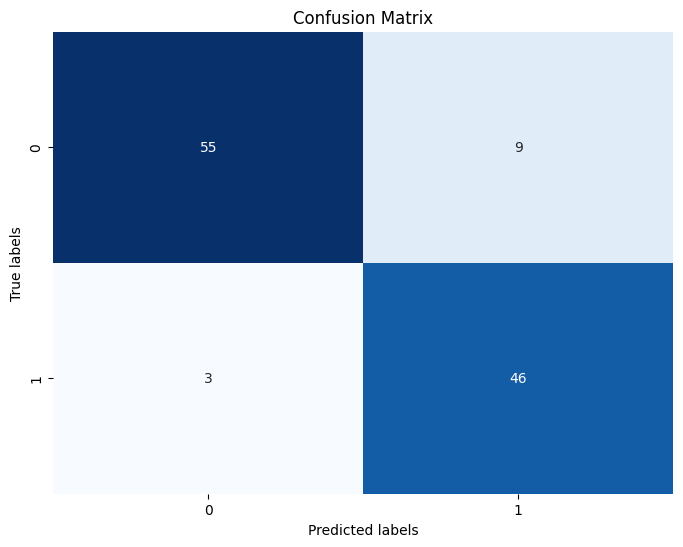

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


17/17 [==============================] - 1s 30ms/step


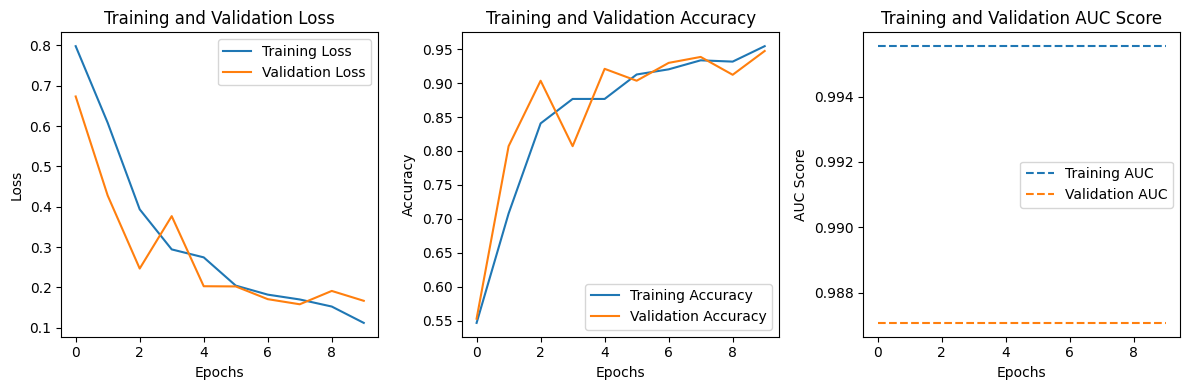

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

val_predictions = model.predict(val_images_np)
train_predictions = model.predict(train_images_np)

train_auc = roc_auc_score(encoded_train_labels, train_predictions[:, 1])
val_auc = roc_auc_score(encoded_val_labels, val_predictions[:, 1])

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot([train_auc] * len(train_loss), label='Training AUC', linestyle='--')
plt.plot([val_auc] * len(val_loss), label='Validation AUC', linestyle='--')
plt.title('Training and Validation AUC Score')
plt.xlabel('Epochs')
plt.ylabel('AUC Score')
plt.legend()

plt.tight_layout()

plt.savefig('metrics_plot2.jpg', format='jpeg', dpi=300)
plt.show()

